In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("--- Cargando datos y modelos para comparación ---")

try:
    # Cargar X e y procesados (después de imputación, antes de ColumnTransformer)
    X_processed = pd.read_csv('./data/processed/X_processed.csv')
    y_processed = pd.read_csv('./data/processed/y_processed.csv').values.ravel() # .ravel() para convertir a 1D

    # Cargar el LabelEncoder de la variable objetivo
    le_target = joblib.load('./models/label_encoder_target.joblib')
    target_names = le_target.classes_ # Nombres de las clases para reportes

    # Cargar los mejores modelos entrenados
    best_rf_model = joblib.load('./models/best_random_forest_model.joblib')
    best_lr_model = joblib.load('./models/best_logistic_regression_model.joblib')

    print("Datos y modelos cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}. Asegúrate de que los notebooks anteriores se hayan ejecutado.")


--- Cargando datos y modelos para comparación ---
Datos y modelos cargados exitosamente.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed
)
print(f"Conjunto de prueba creado: X_test shape {X_test.shape}, y_test shape {y_test.shape}")


Conjunto de prueba creado: X_test shape (2000, 13), y_test shape (2000,)


In [4]:
# --- 3. Realizar Predicciones ---
print("\n--- Realizando predicciones en el conjunto de prueba ---")
y_pred_rf = best_rf_model.predict(X_test)
y_pred_lr = best_lr_model.predict(X_test)

print("Predicciones de Random Forest realizadas.")
print("Predicciones de Regresión Logística realizadas.")



--- Realizando predicciones en el conjunto de prueba ---
Predicciones de Random Forest realizadas.
Predicciones de Regresión Logística realizadas.


In [5]:
# --- 4. Evaluación Individual de Modelos ---
print("\n--- Evaluación Individual de Modelos ---")

print("\n--- Random Forest Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print(f"F1-Macro Random Forest: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")

print("\n--- Regresión Logística Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_lr, target_names=target_names))
print(f"F1-Macro Regresión Logística: {f1_score(y_test, y_pred_lr, average='macro'):.4f}")



--- Evaluación Individual de Modelos ---

--- Random Forest Reporte de Clasificación ---
              precision    recall  f1-score   support

        High       0.96      0.93      0.94       474
         Low       0.98      0.89      0.93       348
      Medium       0.94      0.98      0.96      1178

    accuracy                           0.95      2000
   macro avg       0.96      0.93      0.95      2000
weighted avg       0.95      0.95      0.95      2000

F1-Macro Random Forest: 0.9454

--- Regresión Logística Reporte de Clasificación ---
              precision    recall  f1-score   support

        High       0.94      0.90      0.92       474
         Low       0.98      0.87      0.92       348
      Medium       0.93      0.97      0.95      1178

    accuracy                           0.94      2000
   macro avg       0.95      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000

F1-Macro Regresión Logística: 0.9309


In [8]:
print("\n--- Análisis de Concordancia entre Modelos ---")

# Es una matriz que muestra cuántas veces ambos modelos predijeron lo mismo (acuerdo)
# y cuántas veces sus predicciones difirieron para cada clase.
concordance_matrix = pd.crosstab(
    pd.Series(y_pred_rf, name='Predicción RF'),
    pd.Series(y_pred_lr, name='Predicción LR')
)
print("\nMatriz de Concordancia (RF vs LR):")
display(concordance_matrix)



--- Análisis de Concordancia entre Modelos ---

Matriz de Concordancia (RF vs LR):


Predicción LR,0,1,2
Predicción RF,,,
0,435,0,27
1,0,293,22
2,21,15,1187


In [9]:
# Mide el acuerdo entre dos evaluadores (en este caso, dos modelos) más allá del azar.
# Valores: <0.20 (acuerdo pobre), 0.21-0.40 (aceptable), 0.41-0.60 (moderado),
# 0.61-0.80 (sustancial), 0.81-1.00 (casi perfecto).
kappa_rf_lr = cohen_kappa_score(y_pred_rf, y_pred_lr)
print(f"\nKappa de Cohen (Acuerdo entre RF y LR): {kappa_rf_lr:.4f}")


Kappa de Cohen (Acuerdo entre RF y LR): 0.9220


In [10]:
# Mide la similitud entre los conjuntos de predicciones. Útil si las predicciones se pueden ver como conjuntos.
# Por ejemplo, si se predice un 'riesgo alto' o no.
# Para clasificación multiclase, se puede calcular por clase o promediar.
# Aquí, lo calculamos para el acuerdo total entre las predicciones.
jaccard = jaccard_score(y_pred_rf, y_pred_lr, average='macro') # promedio multiclase
print(f"Índice de Jaccard (Acuerdo entre RF y LR): {jaccard:.4f}")

Índice de Jaccard (Acuerdo entre RF y LR): 0.9072


In [13]:
# Puedes identificar las instancias donde los modelos no están de acuerdo.
disagreements_idx = np.where(y_pred_rf != y_pred_lr)[0]
print(f"\nNúmero de instancias donde RF y LR no están de acuerdo: {len(disagreements_idx)} de {len(y_test)}")
if len(disagreements_idx) > 0:
    print("\nEjemplos de desacuerdos:")
    disagreements_df = pd.DataFrame({
        'Real': y_test[disagreements_idx],
        'Predicción RF': y_pred_rf[disagreements_idx],
        'Predicción LR': y_pred_lr[disagreements_idx]
    })
    # Opcional: Decodificar las etiquetas para que sean legibles si usaste LabelEncoder
    disagreements_df['Real_Decoded'] = le_target.inverse_transform(disagreements_df['Real'])
    disagreements_df['Predicción RF_Decoded'] = le_target.inverse_transform(disagreements_df['Predicción RF'])
    disagreements_df['Predicción LR_Decoded'] = le_target.inverse_transform(disagreements_df['Predicción LR'])

    display(disagreements_df.head(10)) # Muestra las primeras 10 instancias de desacuerdo



Número de instancias donde RF y LR no están de acuerdo: 85 de 2000

Ejemplos de desacuerdos:


,Real,Predicción RF,Predicción LR,Real_Decoded,Predicción RF_Decoded,Predicción LR_Decoded
0,0,0,2,High,High,Medium
1,2,2,0,Medium,Medium,High
2,1,2,1,Low,Medium,Low
3,2,2,0,Medium,Medium,High
4,0,0,2,High,High,Medium
5,2,2,0,Medium,Medium,High
6,0,0,2,High,High,Medium
7,2,2,0,Medium,Medium,High
8,1,1,2,Low,Low,Medium
9,1,1,2,Low,Low,Medium


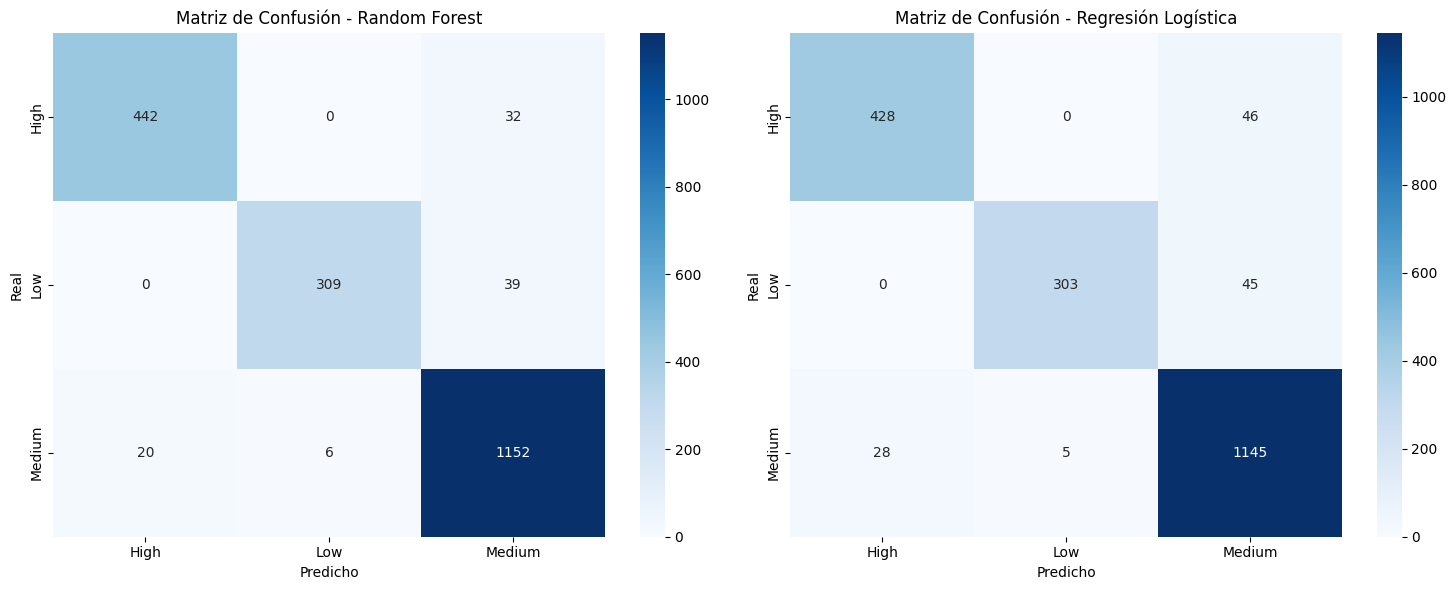

In [14]:
# Puedes visualizar dónde se producen los desacuerdos en la matriz de confusión
# por modelo, o incluso una matriz que combine los errores de ambos.

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión para Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_title('Matriz de Confusión - Random Forest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Matriz de confusión para Regresión Logística
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_title('Matriz de Confusión - Regresión Logística')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

In [16]:




# Identificar los índices de los errores
errors_rf_idx = np.where(y_pred_rf != y_test)[0]
errors_lr_idx = np.where(y_pred_lr != y_test)[0]

# Calcular el número total de instancias en el conjunto de prueba
total_test_instances = len(y_test) # O len(X_test) si lo prefieres, debería ser lo mismo

# Número de errores únicos por modelo
num_errors_rf = len(errors_rf_idx)
num_errors_lr = len(errors_lr_idx)

# Errores comunes (ambos modelos fallan en la misma instancia)
common_errors_idx = np.intersect1d(errors_rf_idx, errors_lr_idx)
num_common_errors = len(common_errors_idx)

# Errores específicos de RF (LR acierta donde RF falla)
rf_only_errors_idx = np.setdiff1d(errors_rf_idx, errors_lr_idx)
num_rf_only_errors = len(rf_only_errors_idx)

# Errores específicos de LR (RF acierta donde LR falla)
lr_only_errors_idx = np.setdiff1d(errors_lr_idx, errors_rf_idx)
num_lr_only_errors = len(lr_only_errors_idx)


# --- Imprimir Resultados en Número y Porcentaje ---
print("\n--- Análisis Detallado de Errores ---")
print(f"Total de instancias en el conjunto de prueba: {total_test_instances}")

print(f"\nErrores de **Random Forest (RF)**:")
print(f"  - Número de instancias: {num_errors_rf}")
print(f"  - Porcentaje del total de prueba: {num_errors_rf / total_test_instances:.2%}")

print(f"\nErrores de **Regresión Logística (LR)**:")
print(f"  - Número de instancias: {num_errors_lr}")
print(f"  - Porcentaje del total de prueba: {num_errors_lr / total_test_instances:.2%}")

print(f"\n**Errores Comunes** (ambos modelos fallan en la misma instancia):")
print(f"  - Número de instancias: {num_common_errors}")
print(f"  - Porcentaje del total de prueba: {num_common_errors / total_test_instances:.2%}")
print(f"  - Porcentaje de los errores de RF: {num_common_errors / num_errors_rf:.2%}" if num_errors_rf > 0 else "N/A")
print(f"  - Porcentaje de los errores de LR: {num_common_errors / num_errors_lr:.2%}" if num_errors_lr > 0 else "N/A")


print(f"\n**Errores solo de RF** (LR acierta donde RF falla):")
print(f"  - Número de instancias: {num_rf_only_errors}")
print(f"  - Porcentaje del total de prueba: {num_rf_only_errors / total_test_instances:.2%}")
print(f"  - Porcentaje de los errores de RF: {num_rf_only_errors / num_errors_rf:.2%}" if num_errors_rf > 0 else "N/A")

print(f"\n**Errores solo de LR** (RF acierta donde LR falla):")
print(f"  - Número de instancias: {num_lr_only_errors}")
print(f"  - Porcentaje del total de prueba: {num_lr_only_errors / total_test_instances:.2%}")
print(f"  - Porcentaje de los errores de LR: {num_lr_only_errors / num_errors_lr:.2%}" if num_errors_lr > 0 else "N/A")

# Opcional: Verificación de la suma de errores únicos y comunes
# La suma de errores solo de RF, errores solo de LR y errores comunes
# debería ser igual a la unión de los errores de RF y LR.
total_unique_errors_union = num_rf_only_errors + num_lr_only_errors + num_common_errors
print(f"\nSuma de errores únicos (RF + LR) + comunes: {total_unique_errors_union}")
print(f"Unión de los errores de RF y LR (total de instancias donde al menos un modelo falló): {len(np.union1d(errors_rf_idx, errors_lr_idx))}")


--- Análisis Detallado de Errores ---
Total de instancias en el conjunto de prueba: 2000

Errores de **Random Forest (RF)**:
  - Número de instancias: 97
  - Porcentaje del total de prueba: 4.85%

Errores de **Regresión Logística (LR)**:
  - Número de instancias: 124
  - Porcentaje del total de prueba: 6.20%

**Errores Comunes** (ambos modelos fallan en la misma instancia):
  - Número de instancias: 68
  - Porcentaje del total de prueba: 3.40%
  - Porcentaje de los errores de RF: 70.10%
  - Porcentaje de los errores de LR: 54.84%

**Errores solo de RF** (LR acierta donde RF falla):
  - Número de instancias: 29
  - Porcentaje del total de prueba: 1.45%
  - Porcentaje de los errores de RF: 29.90%

**Errores solo de LR** (RF acierta donde LR falla):
  - Número de instancias: 56
  - Porcentaje del total de prueba: 2.80%
  - Porcentaje de los errores de LR: 45.16%

Suma de errores únicos (RF + LR) + comunes: 153
Unión de los errores de RF y LR (total de instancias donde al menos un modelo 